# 验证小市值结合盈利指标过滤策略

In [1]:
#常规库引用
import datetime
import tushare as ts
# import rqalpha_data
import pandas as pd
import numpy as np
import tushare as ts
import baostock as bs
import talib as talib
import seaborn as sns
import math
import statsmodels.tsa.stattools as stattool
import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize'] = (18.0, 6.0)
from sqlalchemy import create_engine

engine = create_engine("mysql+pymysql://{}:{}@{}/{}?charset={}".format('root', '12345678', '127.0.0.1:3306', 'finance','UTF8MB4'))
conn = engine.connect()#创建连接

In [30]:
datas=pd.DataFrame()
#flowmkt<=40,大概是50%分位数，为了减少数据量提前过滤
for sscode in ['000','001','002','300','600','601','603'][:]:
    datas=pd.concat([datas,pd.read_sql('select * from k'+sscode+' where date>"2016-01-01" \
                                       AND isST=0 AND eprofit>1  AND flowmkt<=60  AND esale>0 \
                                       AND pctChg>-9.7 AND pctChg<=9.7 AND turn>=0.5 order by date \
                                       ',con=conn)],axis=0)
print(datas.shape)
datas=datas[datas.groupby('date')['flowmkt'].rank()<=250]
print(datas.shape)


(1332913, 24)
(228430, 24)


In [31]:
n=200
sdata=datas
# sdata['amo']=sdata.close/sdata.emoney
sdata['ape']=sdata.close/sdata.eprofit
sdata['asa']=sdata.close/sdata.esale
sdata['result2']=sdata.result
sdata.drop(['close','open','preclose','high','low','amount','volume','isST','eb','emoney','esale','result'],axis=1,inplace=True)
print(datas.shape)
datas=datas[datas.groupby('date')['ape'].rank()<=n]
print(datas.shape,sdata.shape)

(228430, 15)
(182782, 15) (228430, 15)


[-193.11, -110.04, -40.03, 88.52]
[343.01, 399.55, 122.52, 94.81]
[396.47, 439.14, 184.96, 81.99]
[419.43, 486.3, 126.51, 72.1]
[249.88, 350.18, 53.26, 74.1]


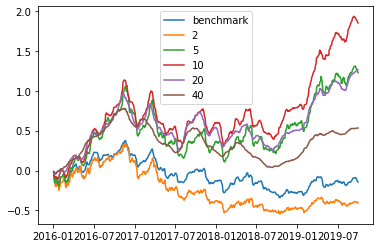

In [39]:
stock_data=datas[:-40].copy()

output=pd.DataFrame()
output['monthresult']=sdata.groupby('date')['result5'].mean()
# print(stock_data.shape,stock_data.columns)
i,j,k=int(n*0.95),0.3,2
turnmin,turnmax,volrmin,volrmax=2,8,6,20
stock_data=stock_data[stock_data['turn']>turnmin]  
stock_data=stock_data[stock_data['turn']<turnmax]
stock_data=stock_data[stock_data['volratio']>volrmin*0.1]  
stock_data=stock_data[stock_data['volratio']<volrmax*0.1]
stock_data=stock_data[stock_data.groupby('date')['asa'].rank()<i]  
stock_data=stock_data[stock_data.groupby('date')['ape'].rank()<int(j*i)]  
stock_data=stock_data[stock_data.groupby('date')['flowmkt'].rank()<=k]

#计算选中的股票在下月的涨幅
output['line_benchmark']=(0.01*output['monthresult']/5+1).cumprod()-1
plt.plot(output['line_benchmark'],label='benchmark')
for mm in [2,5,10,20,40]:
    output['selectresult']=stock_data.groupby('date')['result'+str(mm)].mean()
    output['line']=(0.01*output['selectresult']/mm+1).cumprod()-1
    plt.plot(output['line'],label=str(mm))
    plt.legend()

    sharpratio=(output.line.dropna(axis=0)[-1]-0.050)/output.line.std()  #以5%作为无风险收益率
    inforatio=(output.line[-1]-output.line_benchmark[-1])/output.line.std()
    rj = np.argmax(np.maximum.accumulate(output.line)-output.line)
    backd = (output.line[np.argmax(output.line[:rj])] - output.line[rj])
    print([round(100*sharpratio,2),round(100*inforatio,2),round(100*output.line[-1],2),round(100*backd,2)])

## 由此可见ape、asa、flowmkt三个指标结合（舍去前最突出的几个），配合量比、换手率指标，5-10日调仓，远远跑赢大盘

### 搜索最佳参数

In [40]:
for turnmin in range(0,4,1):#4
    for turnmax in range(8,20,3):#4
        for volrmin in range(5,10,1):#4
            for volrmax in range(20,28,2):#4
                results=[]
                for i in [0.5,0.6,0.7,0.8,0.9]:#8
                    for j in [0.5,0.6,0.7,0.8,0.9]:#5
                        for k in range(1,5,1): #4

                            stock_data=datas[:-40].copy()
                            stock_data=stock_data[stock_data['turn']>turnmin]  
                            stock_data=stock_data[stock_data['turn']<turnmax]
                            stock_data=stock_data[stock_data['volratio']>volrmin*0.1]  
                            stock_data=stock_data[stock_data['volratio']<volrmax*0.1]
                            stock_data=stock_data[stock_data.groupby('date')['asa'].rank()<int(n*i)]  
                            stock_data=stock_data[stock_data.groupby('date')['ape'].rank()<int(j*n*i)]  
#                             print(stock_data.shape)
                            stock_data=stock_data[stock_data.groupby('date')['flowmkt'].rank()<=k]
                            #计算选中的股票在下月的涨幅
# 
                            backtests=[]
                            for mm in [2,5,10,20,40]:
                                output['selectresult']=stock_data.groupby('date')['result'+str(mm)].mean()#输出选择股票和资金曲线
                                output['line'+str(mm)]=(0.01*output['selectresult']/mm+1).cumprod()-1
#                                 plt.plot(output['line'+str(mm)],label=str(mm))
#                                 plt.legend()
                                output['selectresult']=stock_data.groupby('date')['result'+str(mm)].mean()
                                output['line']=(0.01*output['selectresult']/mm+1).cumprod()-1
                                sharpratio=(output.line.dropna(axis=0)[-1]-0.050)/output.line.std()  #以5%作为无风险收益率
                                inforatio=(output.line[-1]-output.line_benchmark[-1])/output.line.std()
                                rj = np.argmax(np.maximum.accumulate(output.line)-output.line)
                                backd = (output.line[np.argmax(output.line[:rj])] - output.line[rj])
                                backtests.append([round(100*sharpratio,2),round(100*inforatio,2),round(100*output.line[-1],2),round(100*backd,2)])
                            backtests=np.array(backtests).reshape(20)
                            para=np.array([n,n*i,n*i*j,k,turnmin,turnmax,volrmin,volrmax])
                            res=np.r_[para,backtests]
                            results.append(res)
                m=pd.DataFrame(results,columns=['n','i','j','k','turnmin','turnmax','volrmin','volrmax','sha2','inf2',
                                'profit2','backd2','sha5','inf5','profit5','backd5','sha10','inf10','profit10','backd10',
                                'sha20','inf20','profit20','backd20','sha40','inf40','profit40','backd40'])
                m.to_sql(name='minimkt2',if_exists='append',con=conn)
                print(turnmin,turnmax,volrmin,volrmax,'ok',backtests[-1])



/Users/hongyuouyang/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


KeyboardInterrupt: 

In [ ]:
import threading
threads=[]
jlen=0

for turnmin in range(0,4,1):#4
    threads.append(threading.Thread(target=touchpara,args=(turnmin,)))
    threads[jlen].start()
    jlen+=1

for i in range(jlen):
    threads[i].join()
# touchpara()

/Users/hongyuouyang/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


3 8 6 20 ok 61.76
2 8 6 20 ok 66.75
1 8 6 20 ok 67.6
0 8 6 20 ok 63.45
3 8 6 22 ok 61.3
2 8 6 22 ok 8.7
